# 1.1 Radial velocity analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2024-2025 exercise 1

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 21.4.2025

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).


## (The absolute basics of) radial velocities

A planet orbiting a star causes the star to [move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity,
and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

![Doppler shift vs time](Doppler_Shift_vs_Time.svg "Doppler shift vs time")


A planet with a mass $M_\mathrm{p}$ orbiting a star with a mass $M_\star$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}},
$$

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$, and $M_\star$ we can solve for the minimum planetary mass $M_\mathrm{p} \sin i$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.


## (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a *parameter estimation* problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://ui.adsabs.harvard.edu/link_gateway/2018haex.bookE.149P/EPRINT_PDF) and the references therein.

## Initialisation

In [274]:
%matplotlib inline

In [275]:
import pandas as pd
import astropy.units as u

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, median
from astropy.table import Table
from astropy.timeseries import LombScargle
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [276]:
rv_data = Table.read('data/wasp_12b_yee_2019.dat', format='ascii.cds')

It's important to understand what sort of data we're dealing with, so we begin by displaying the table header and the five first rows.

In [277]:
rv_data[:5]  

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

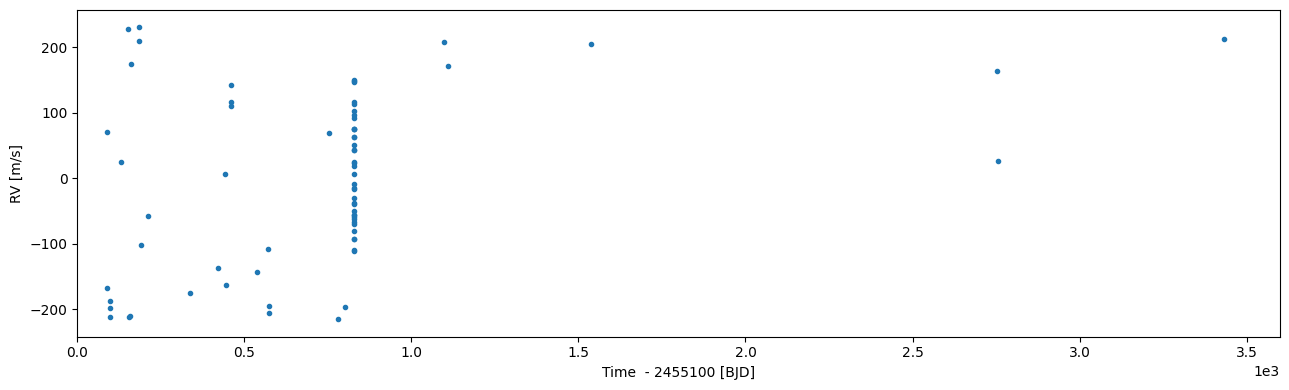

In [278]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>

1. Try to describe the logic behind the time sampling of the RV observations.

To detect significant variations of the radial velocity of a star, an thus the possible presence of an object orbiting around it, the radial velocity of the star is measured at irregularly spaced epochs, as we see in the plot above. If measured at regular intervals, the periodicity of the signal wouldn't in fact  allow us to detect the variation. 

Focusing on the more sampled time-span, this corresponds to the needed data to characterize the planet and detemrine its $M_p \sin(i)$ value. These short-spaced data allow to confirm the periodicity of the signal and the eventual presence of the planet.

The long time-span over which data are collected can be useful to detect long term variations in the star-planet system. 

It is to be kept in mind that the data availability is at all times also influenced by the visibility conditions and availability of the instrument. 


2. Plot below the RV observations as a function of time focusing on the densely-sampled time-span.

0.010845000389963388
3
2455559.917563
0.010288999881595373
4
2455559.927852
0.005045999772846699
13
2455928.78876
0.005104000214487314
14
2455928.793864
0.02891199989244342
15
2455928.822776
0.005994999781250954
16
2455928.828771
0.0060880002565681934
17
2455928.834859
0.0062500000931322575
18
2455928.841109
0.00612299982458353
19
2455928.847232
0.006064999848604202
20
2455928.853297
0.005856000352650881
21
2455928.859153
0.005833999719470739
22
2455928.864987
0.005752000026404858
23
2455928.870739
0.00584500003606081
24
2455928.876584
0.005729000084102154
25
2455928.882313
0.00583299994468689
26
2455928.888146
0.005694999825209379
27
2455928.893841
0.005798000376671553
28
2455928.899639
0.0060189999639987946
29
2455928.905658
0.0065739997662603855
30
2455928.912232
0.0063310000114142895
31
2455928.918563
0.005925000179558992
32
2455928.924488
0.0059369998052716255
33
2455928.930425
0.0056950002908706665
34
2455928.93612
0.005589999724179506
35
2455928.94171
0.005683000199496746
36
245

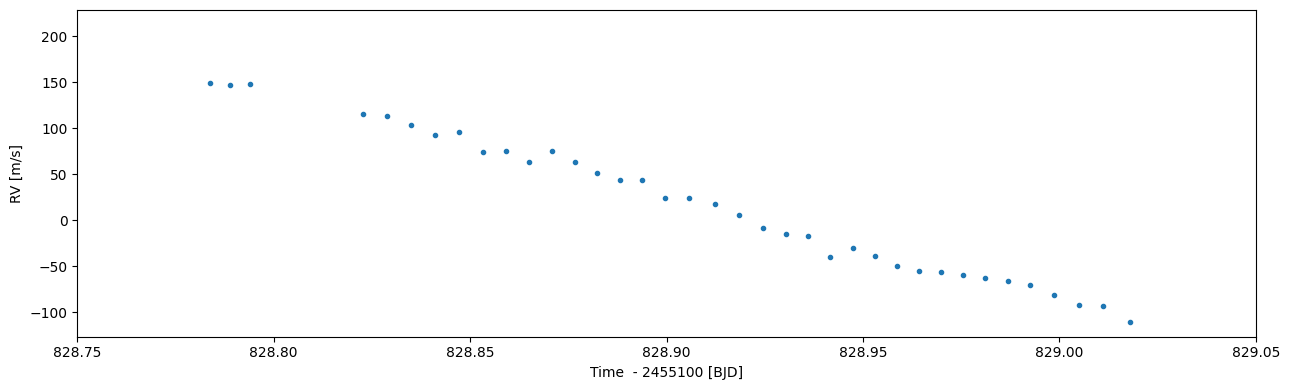

In [279]:
# plot the RV observations as a function of time focusing on the densily samples time-span 
# rv_data_dense = pd.DataFrame()
rv_data_dense = pd.DataFrame({'BJD': [],'RVel': [], 'e_RVel': []})

for i in range(len(rv_data['BJD'])-1):
    if float(rv_data['BJD'][i+1]) - float(rv_data['BJD'][i]) <= 0.1:
        print(float(rv_data['BJD'][i+1]) - float(rv_data['BJD'][i]))
        print(i)
        print(rv_data['BJD'][i+1])
        rv_data_dense.loc[i,'BJD'] = rv_data['BJD'][i]
        rv_data_dense.loc[i,'RVel'] = rv_data['RVel'][i]
        rv_data_dense.loc[i,'e_Rvel'] = rv_data['e_RVel'][i]

fig, ax = subplots()
ax.errorbar(rv_data_dense['BJD'] - 2455100, rv_data_dense['RVel'], rv_data_dense['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.75, 829.05))
#ax.set_xlim([0.5,1.2])
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [280]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

Next, we use the `LombScargle.autopower` to calculate the periodogram. We restrict the search to $0.5 < P < 5$ days.

In [281]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [282]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

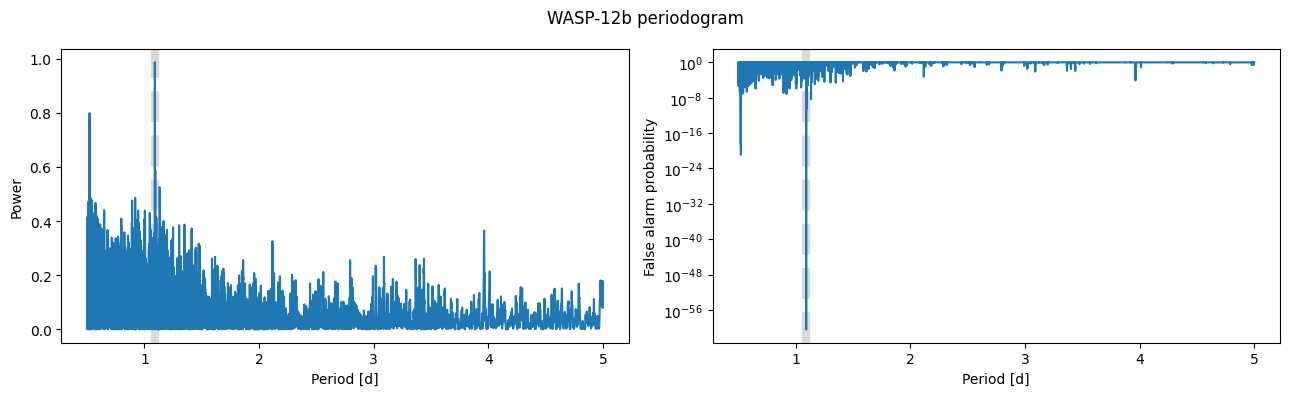

In [283]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

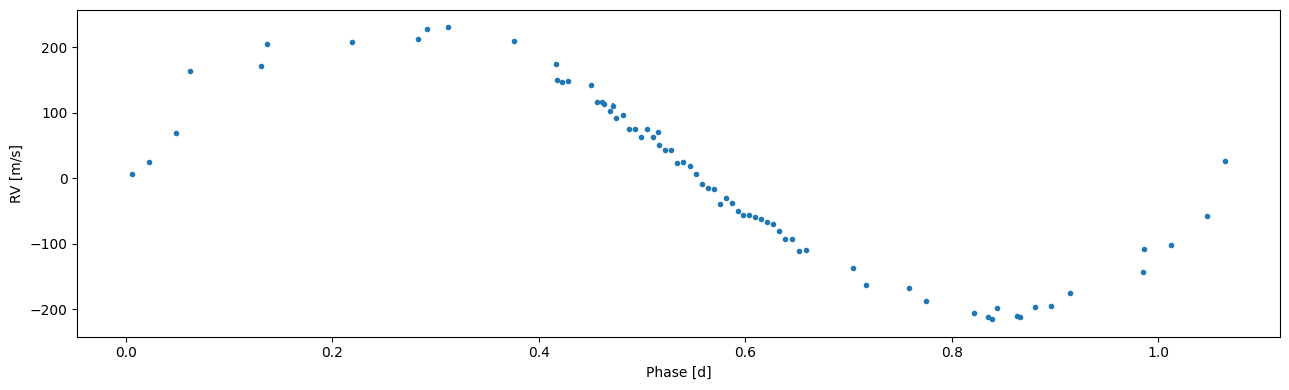

In [284]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [285]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

In [286]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope_1     N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

The parameters are

- `tc_1`: transit center [BJD]
- `p_1`: orbital period [d]
- `secw_1`: $\sqrt{e} \cos\omega$, where $e$ is the eccentricity and $\omega$ the argument of periastron
- `sesw_1`: $\sqrt{e} \sin\omega$
- `rv_shift_0`: systemic velocity [m/s]
- `rv_err_0`: additional white noise [m/s]
- `rv_k_1` RV semiamplitude [m/s]
- `rv_slope`: additional linear slope

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [287]:
lpf.set_prior('tc_1', 'NP', 2458480.65, 0.02) # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', 1.09, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)
lpf.set_prior('rv_slope_1', 'UP', 0.0, 1e-5)

In [288]:
lpf.ps

[  0 |G| tc_1           N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.09, σ = 0.1)                     [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope_1     U(a = 0.0, b = 1e-05)                    [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

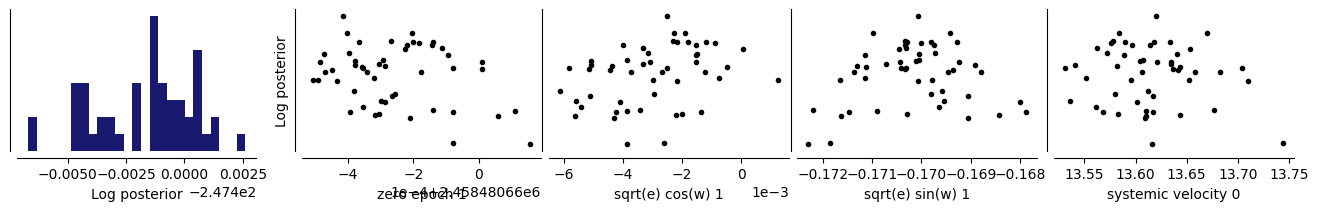

In [289]:
lpf.optimize_global(2000)

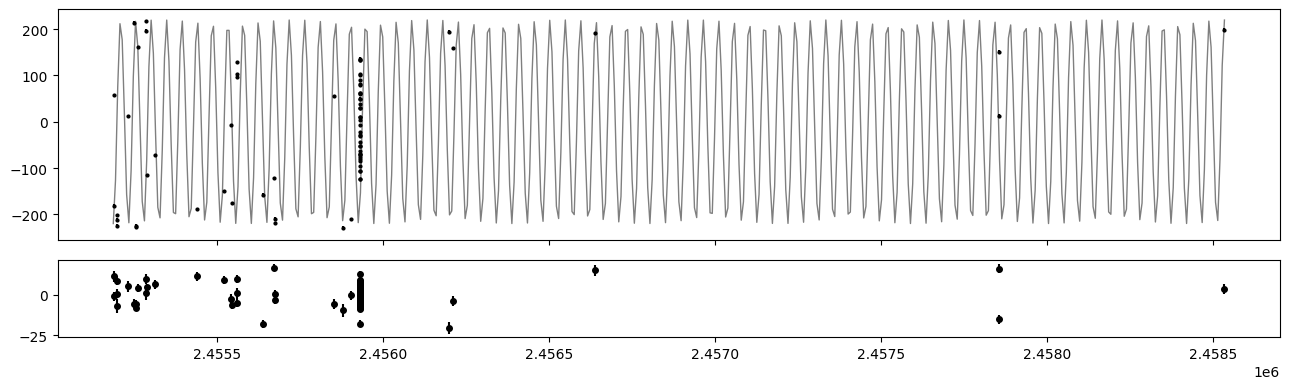

In [290]:
lpf.plot_rv_vs_time();

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytransit/lpf/rvlpf.py:370: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


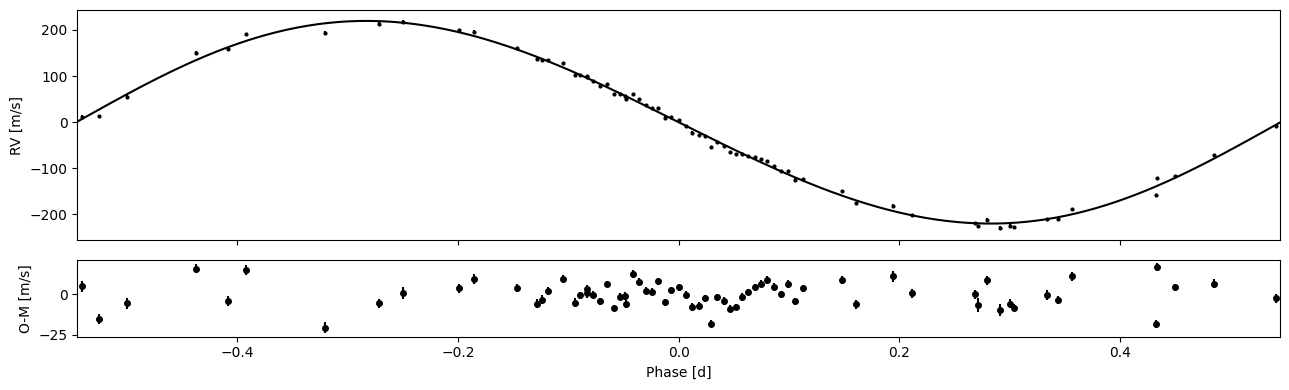

In [291]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [292]:
lpf.sample_mcmc(niter=2000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]

The *emcee* sampler uses an ensemble of MCMC chains to sample the posterior. This means that we have many chains running in parallel. We can plot the traces of each chain to see how the chain population behaves in time.

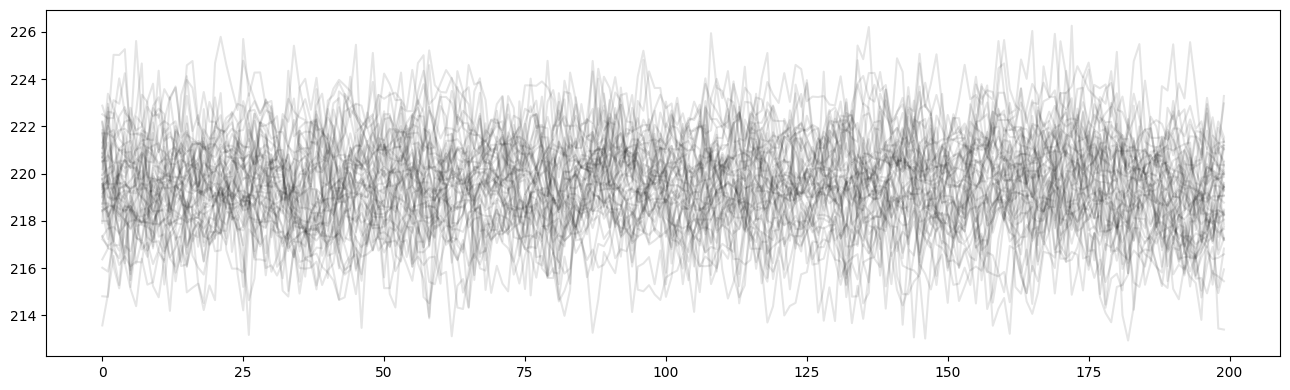

In [293]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

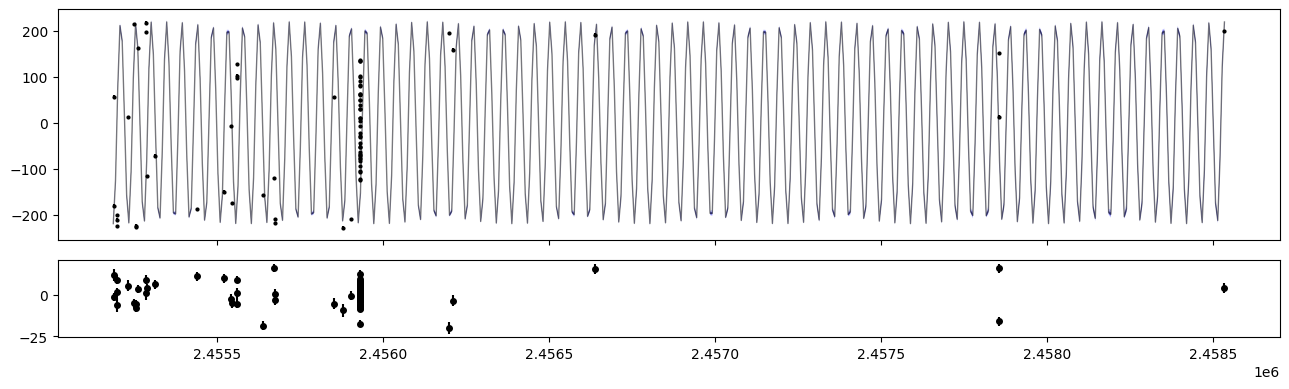

In [294]:
lpf.plot_rv_vs_time('mcmc');

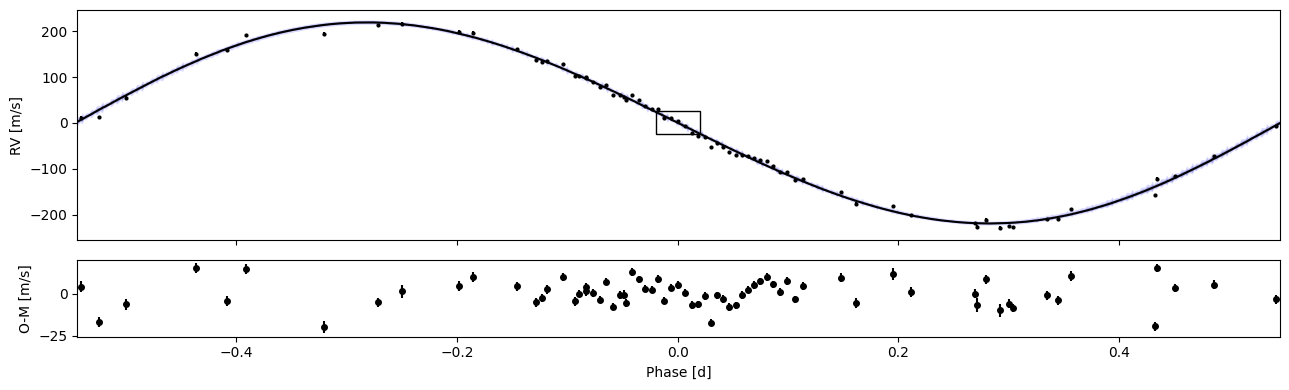

In [295]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

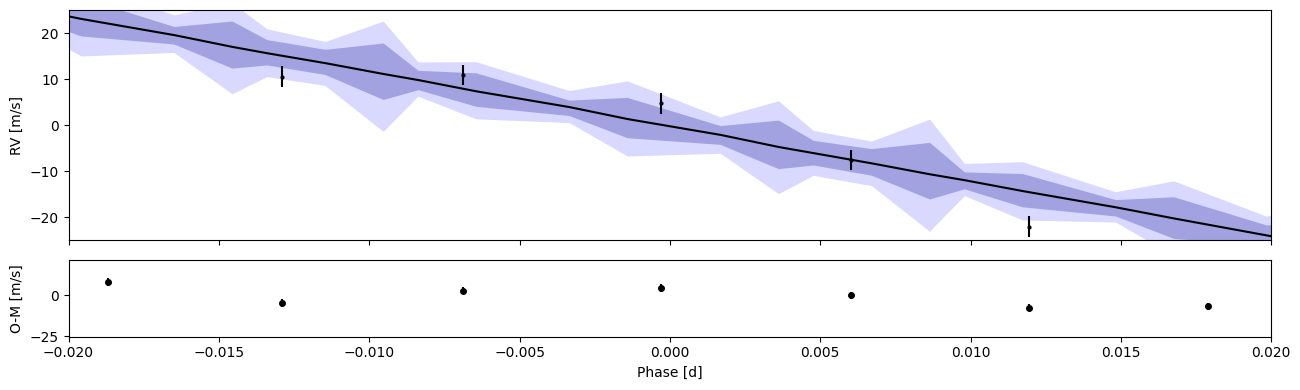

In [296]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [297]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope_1
0,2.458481e+06,1.091424,0.037626,-0.148100,14.930484,5.938418,219.314587,7.419542e-06
1,2.458481e+06,1.091422,0.012175,-0.155938,13.738239,6.685847,218.202646,6.789266e-06
2,2.458481e+06,1.091422,-0.029946,-0.159336,13.246667,6.616995,216.061799,7.016444e-06
3,2.458481e+06,1.091421,-0.048230,-0.157814,12.526953,7.334876,215.141172,4.877309e-06
4,2.458481e+06,1.091421,-0.052909,-0.122269,12.603788,7.773085,216.953868,6.986522e-06
...,...,...,...,...,...,...,...,...
9995,2.458481e+06,1.091420,0.024271,-0.150686,13.837293,8.981779,217.009508,3.753745e-06
9996,2.458481e+06,1.091419,-0.032872,-0.139531,12.734941,9.215343,217.790657,2.240081e-06
9997,2.458481e+06,1.091419,-0.021023,-0.163976,13.399511,8.662366,217.066654,1.136801e-06
9998,2.458481e+06,1.091419,-0.021518,-0.147689,13.188174,8.423654,218.985205,3.829753e-06


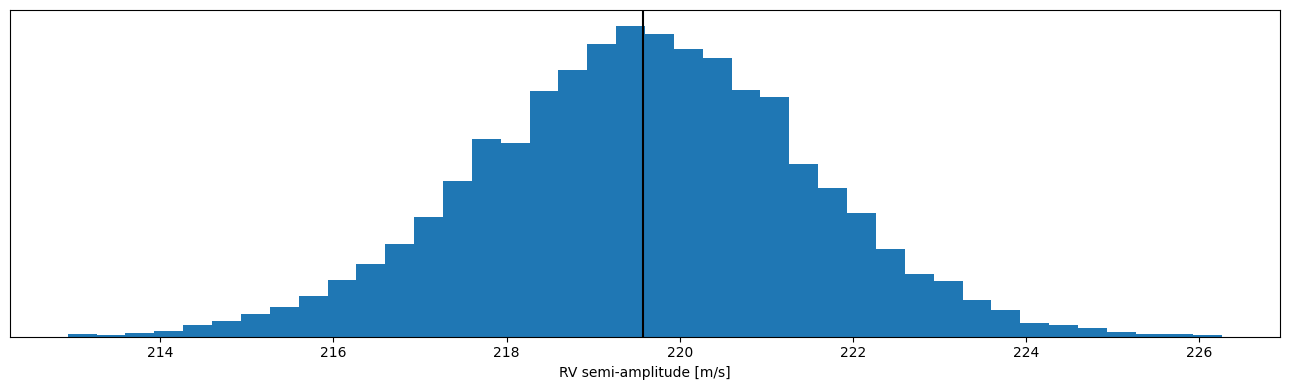

In [298]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

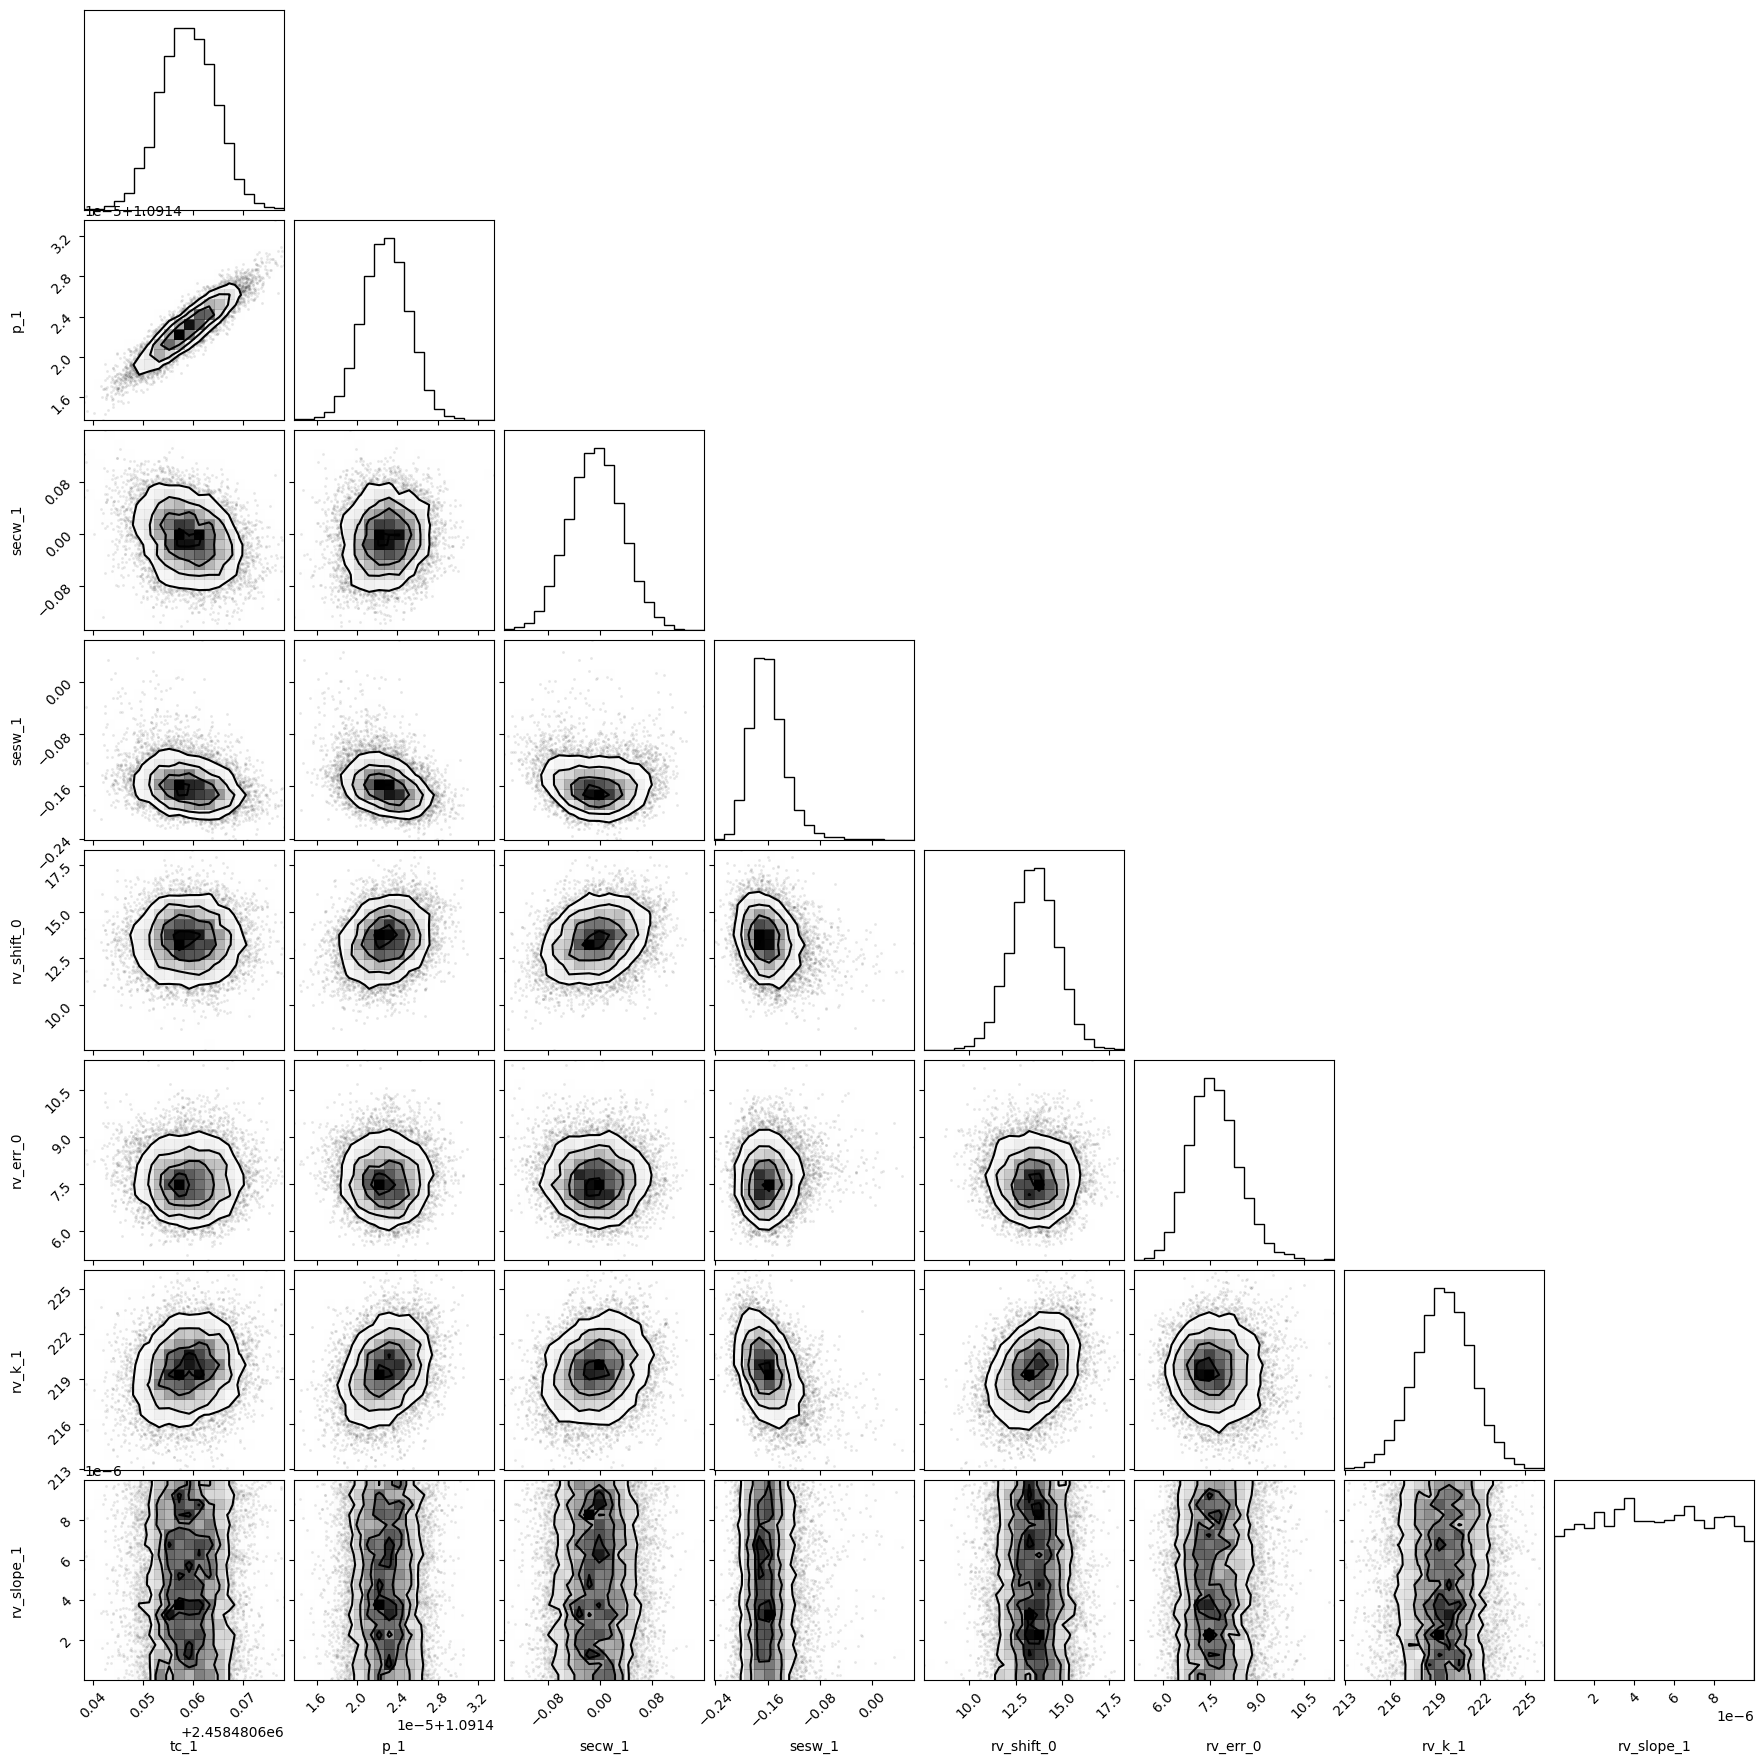

In [299]:
corner(df.values, labels=df.columns);

### <span style="color:darkblue">Questions and exercises</span>

1. We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?

$ \omega = \arctan(\frac{sesw_1}{secw_1})$

Obtenido $\omega$, se puede obtener $e = (\frac{secw_1}{\cos(\omega)})^2$ o igualmente $e = (\frac{sesw_1}{\sin(\omega)})^2$

2. Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.

0      -1.322001
1      -1.492878
2      -1.756571
3      -1.867393
4      -1.979193
          ...   
9995   -1.411099
9996   -1.802165
9997   -1.698311
9998   -1.715477
9999   -1.547637
Name: omega, Length: 10000, dtype: float64
0       0.023349
1       0.024465
2       0.026285
3       0.027231
4       0.017749
          ...   
9995    0.023295
9996    0.020550
9997    0.027330
9998    0.022275
9999    0.026325
Name: ecc, Length: 10000, dtype: float64


Text(0.5, 0, 'ecc')

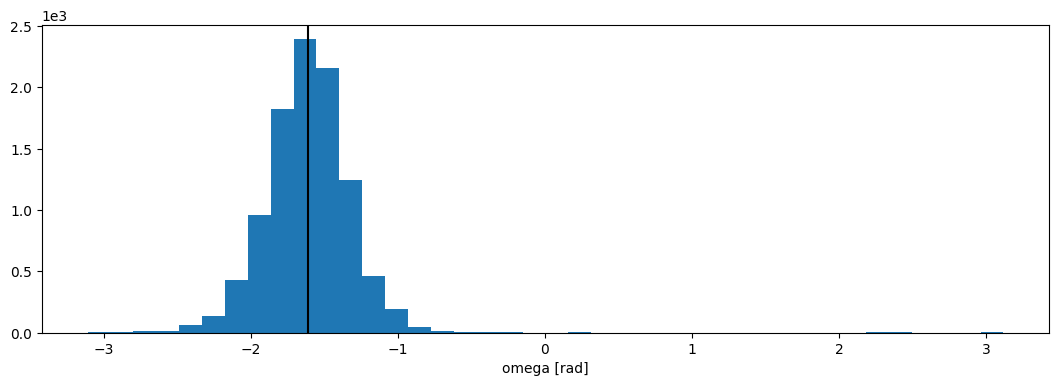

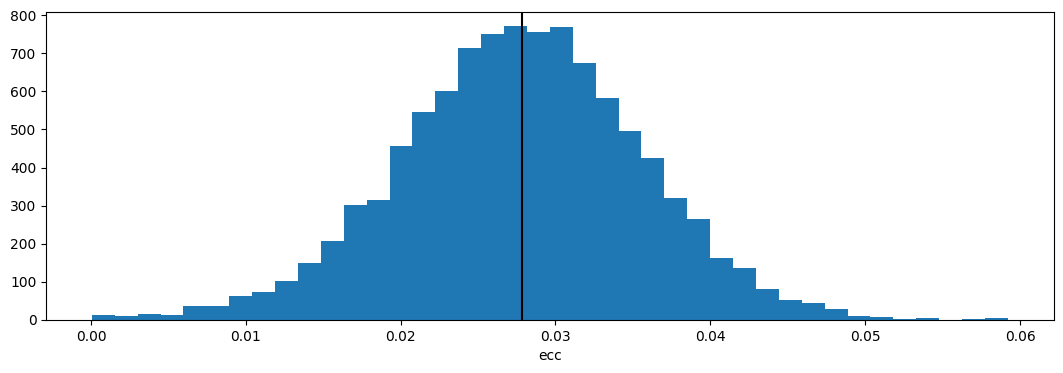

In [300]:
import numpy as np 

for i,el in enumerate(df.secw_1):
    df.loc[i, 'omega'] = np.arctan2(float(df.loc[i, 'sesw_1']) , float(el))
    df.loc[i, 'ecc'] = (el/ np.cos(df.loc[i, 'omega']))**2

print(df.omega)
print(df.ecc)

# plot their histograms 
fig, ax = subplots()
ax.hist(df.omega, bins=40)
ax.axvline(median(df.omega), c='k')
ax.set_xlabel("omega [rad]")

fig, ax = subplots()
ax.hist(df.ecc, bins=40)
ax.axvline(median(df.ecc), c='k')
ax.set_xlabel("ecc")

3. What is the posterior density for the minimum mass ($m\sin i$) of WASP-12b? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.

WASP_12b orbits around WASP12; the mass of this star is estimated to be 1.434 solar masses, as found in literature. 

In the formula used to estimate the mass of the planet, the $M_p$ term in the term $(M_s + M_p)^{2/3}$ is neglected, as it is significantly smaller than the mass of the star. 

The final used formula to estimate $M_p \sin(i)$ is thus: 

$ M_p \sin(i) = K  (\frac{P}{2 \pi G})^{1/3} M_s^{2/3} (1 -e^2)^{1/2}$

0    1.091424
1    1.091422
2    1.091422
3    1.091421
4    1.091421
Name: p_1, dtype: float64
0    94298.992619
1    94298.880084
2    94298.875198
3    94298.790326
4    94298.777841
Name: p_1, dtype: float64


Text(0.5, 0, 'Mpsini / Mj')

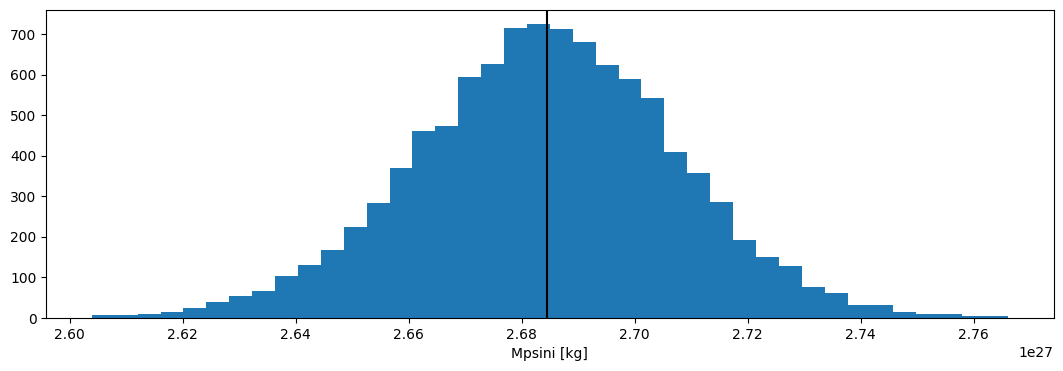

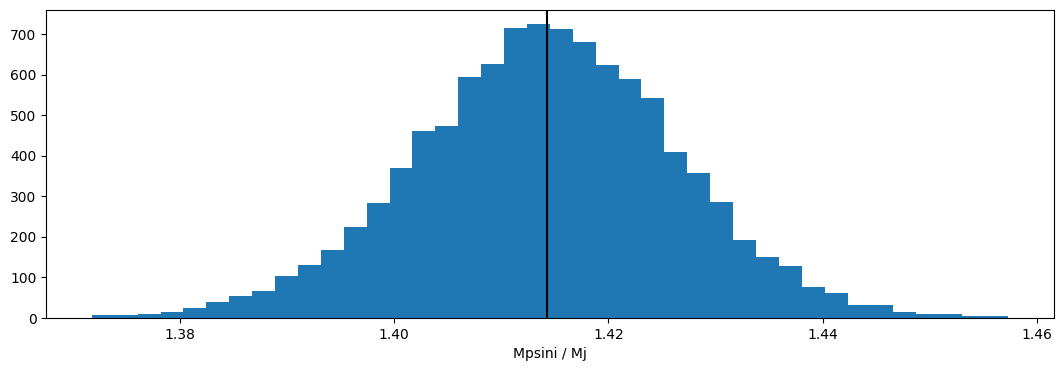

In [301]:
# planet mass estimation

# the period must be expressed in seconds 
print(df.p_1[:5])
for i,el in enumerate(df.p_1):
    df.loc[i, 'p_1'] = float(el)*24*60*60

print(df.p_1[:5])

M_star = 1.434 * 1.988475 * 10**30

for i in range(len(df.p_1)):
    df.loc[i, 'Mpsini'] = float(df.loc[i, 'rv_k_1']) * (float(df.loc[i, 'p_1'])/ (2*np.pi*6.67*10**(-11)))**(1/3)* M_star**(2/3)*(1 - float(df.loc[i, 'ecc']**2))**(1/2)


# do the histogram of the mass expressed in kg 
fig, ax = subplots()
ax.hist(df.Mpsini, bins=40)
ax.axvline(median(df.Mpsini), c='k')
ax.set_xlabel("Mpsini [kg]")

# do the histogram in Jupiter masses 
Mj = 1.89813 * 10**27
fig, ax = subplots()
ax.hist(df.Mpsini / Mj, bins=40)
ax.axvline(median(df.Mpsini / Mj), c='k')
ax.set_xlabel("Mpsini / Mj")


The obtained mass multiplicated by sin(i) is around 2.6765e27 kg.


4. What would be the posterior RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

We use the same formula as before, this time to estimate the radial velocity amplitude instead. 

Get uncertainties on the mass of Earth, period of earth, eccentricity of the Earth. 
Suppose the inclination is pi/2, which means that the term $\sin(i)$ is equal to one, and is thus not explicitely included in the equation.

Uncertainties on the mass of the star are not considered.

[0.07034667517324424, 0.07033441062474453, 0.07034315371339066, 0.070337017498819, 0.07034931512260958, 0.07034121144365389, 0.0703464672388514, 0.07033450476821085, 0.0703362654008067, 0.07034222095504217, 0.07033687776265214, 0.0703324696147244, 0.07034556669057791, 0.07035352477066642, 0.07033225588024974, 0.07034832294325376, 0.07034678831661773, 0.07034251141969705, 0.07033868196977137, 0.07033288929549394, 0.07034682679880351, 0.07035614675707734, 0.07034016876828807, 0.07033540982871457, 0.07034240269261006, 0.07032612377899831, 0.07032899621966957, 0.07035420141570779, 0.07035176094303387, 0.07034414185888595, 0.0703412644475635, 0.0703341236114504, 0.07034421558680187, 0.07034005986126166, 0.07034004765904545, 0.07036202361497347, 0.07034016803835931, 0.07033646812106692, 0.07033155930558063, 0.0703399476746316, 0.0703401283140824, 0.07033155801364117, 0.0703381240809122, 0.07034089947419435, 0.07035105685883354, 0.0703431419720159, 0.07034423429232838, 0.07033553636865825, 0.

Text(0.5, 0, 'RV semi-amplitude [m/s]')

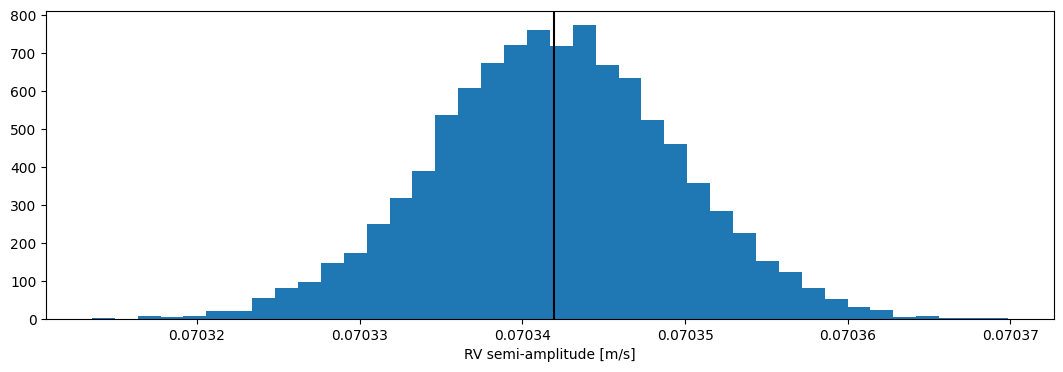

In [302]:
# calculate semi amplitude 
# formula 
def semi_amplitude(P, Mp, ecc):
    Ms =  1.434 * 1.988475 * 10**30
    G = 6.67 * 10**(-11)
    i = np.pi/2  # we assume we are seeing the planet from a perspective and we fix it a pi/2 
    P_sec = P*24*60*60 
    K = ((2*np.pi*G/P_sec)**(1/3))*(Mp/(Ms**(2/3)))* ((1 - ecc**2)**(-1/2))
    return K 

# define parameters
Mp = np.random.normal(loc=5.9722*10**24, scale=0.0006*10**24, size=10000)
ecc = np.random.normal(loc=0.0167086, scale=0.00167, size=10000)
P = np.random.normal(loc=365.256363, scale=10**(-7), size=10000) # !! this is expressed in days 

K_post = []
for i in range(len(Mp)):
    K_post.append(semi_amplitude(P[i], Mp[i], ecc[i]))

print(K_post)

fig, ax = subplots()
ax.hist(K_post, bins=40)
ax.axvline(median(K_post), c='k')
ax.set_xlabel("RV semi-amplitude [m/s]")


---

<center>&copy;2025 Hannu Parviainen</center>